In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install koreanize-matplotlib

In [6]:
import koreanize_matplotlib

In [65]:
# 딕셔너리를 만들 때 필요한 리스트 변수를 만들고 반환하는 함수
def make_var_name_lst():
  var_name_lst = []
  # 각 기업 별로 나누기 위한 변수 만들기
  for i in range(1,5):
    tmp_lst = []
    date_name = '기간'
    profit_name = f'영업이익{i}'
    debt_name = f'부채{i}'
    market_name = f'시가총액{i}'
    tmp_lst.append(date_name)
    tmp_lst.append(profit_name)
    tmp_lst.append(debt_name)
    tmp_lst.append(market_name)
    var_name_lst.append(tmp_lst)
  return var_name_lst

In [66]:
# 각 기업 별 데이터프레임을 만들기 위한 딕셔너리를 만들고 반환하는 함수
def make_dict(country_df, company_lst):

  var_name_lst = make_var_name_lst()

  # 각 기업 별로 데이터프레임 만들기 위한 딕셔너리 만들기
  data_dict = {}
  for company, var in zip(company_lst, var_name_lst):
    data_dict[company] = country_df[var]
  return data_dict

In [59]:
# 각 기업 별 데이터프레임 만들기 위한 함수
def process_company_data(data_dict, company_key, var_name_lst_no_date, index):
  company = data_dict[company_key]
  company.index = company['기간']
  company = company.dropna()

  selected_vars = var_name_lst_no_date[index]
  company = company[selected_vars]
  company_profit_series = company[selected_vars[0]]
  company_debt_series = company[selected_vars[1]]
  company_market_series = company[selected_vars[2]]
  df_ = {
      '영업이익':company_profit_series,
      '부채':company_debt_series,
      '시가총액':company_market_series,
  }
  company_df = pd.DataFrame(df_, index=company.index)

  return company_df

In [81]:
# 해당 산업 내 기업들의 credit risk를 계산해 하나의 데이터프레임으로 만드는 함수
def cal_credit_risk(r, data_dict, company_lst, var_name_lst_no_date):
  series_container = []
  for i in range(len(company_lst)):
    company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
    company_i_profit_series = company_i['영업이익']
    company_i_debt_series = company_i['부채']
    company_i_market_series = company_i['시가총액']

    # recovery rate 계산
    recovery_rate_series_i = company_i_profit_series / company_i_debt_series
    recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
    # 부도확률 계산
    STD_V = company_i_market_series.std()
    R = r
    T = company_i_market_series.shape[0]
    tmp = []
    for V, K in zip(company_i_market_series, company_i_debt_series):
      d1 = (np.log(V/K) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
      d2 = d1 - STD_V * np.sqrt(T)
      # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
      def_prob = norm.logcdf(d2)
      tmp.append(def_prob)
    company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
    company_i_default_rate_series = ((company_i_default_rate_series/company_i_default_rate_series.iloc[0])-1)
    # EAD 계산
    company_i_ead_series = company_i_debt_series
    # credit risk 계산
    company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
    # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
    series_container.append(company_i_cr)

  # 데이터프레임 생성
  df = pd.DataFrame(series_container)
  # 데이터프레임 반환
  return df.T

In [46]:
# 기본 변수들
manu_india = pd.read_excel("/content/인도_제조.xlsx") # make_dict의 매개변수로 쓰일 변수. 바꿔줘야 한다.
company_lst = ['company1', 'company2', 'company3', 'company4']
var_name_lst_no_date = [
    ['영업이익1', '부채1', '시가총액1'],
    ['영업이익2', '부채2', '시가총액2'],
    ['영업이익3', '부채3', '시가총액3'],
    ['영업이익4', '부채4', '시가총액4']
]

In [82]:
R = 0.041
data_dict = make_dict(manu_india, company_lst)
cr_df = cal_credit_risk(R, data_dict, company_lst, var_name_lst_no_date)
# cr_df.shape
# cr_df.plot()
# 각자의 시작 시점이 기준.
cr_df # 음수가 나오면 안 되는데 음수가 나온다.

,0,1,2,3
기간,,,,
2013-03-01,NaN,0.000000e+00,NaN,NaN
2013-06-01,NaN,-1.350360e-07,NaN,NaN
2013-09-01,NaN,-0.000000e+00,NaN,NaN
2013-12-01,NaN,-0.000000e+00,NaN,NaN
2014-03-01,NaN,-5.862610e-06,NaN,NaN
2014-06-01,NaN,-0.000000e+00,NaN,NaN
2014-09-01,0.000000e+00,-2.961323e-06,NaN,NaN
2014-12-01,0.000000e+00,-2.161738e-07,NaN,NaN
2015-03-01,0.000000e+00,0.000000e+00,NaN,NaN


<Axes: xlabel='기간'>

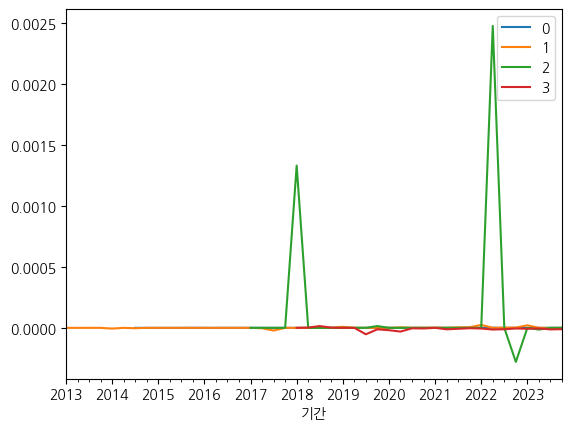

In [83]:
cr_df.plot()

# 실험

In [18]:
company1 = data_dict['company1'][['영업이익1', '부채1', '시가총액1']]
selected_vars = var_name_lst_no_date[0]
company1[selected_vars[0]]

기간
2013-03-01       NaN
2013-06-01       NaN
2013-09-01       NaN
2013-12-01       NaN
2014-03-01       NaN
2014-06-01       NaN
2014-09-01     0.129
2014-12-01     0.133
2015-03-01     0.497
2015-06-01     0.928
2015-09-01     0.605
2015-12-01     0.825
2016-03-01     0.099
2016-06-01     0.109
2016-09-01     0.287
2016-12-01     0.323
2017-03-01     0.174
2017-06-01     0.121
2017-09-01     0.108
2017-12-01     0.099
2018-03-01    -0.353
2018-06-01     0.068
2018-09-01    -0.389
2018-12-01    -1.924
2019-03-01    -2.759
2019-06-01    -0.181
2019-09-01    -1.657
2019-12-01    -0.520
2020-03-01    -0.404
2020-06-01    -0.263
2020-09-01    -0.328
2020-12-01   -10.605
2021-03-01    -0.229
2021-06-01    -0.089
2021-09-01    -0.307
2021-12-01    -0.138
2022-03-01     3.140
2022-06-01     1.057
2022-09-01     0.764
2022-12-01     0.820
2023-03-01     0.923
2023-06-01     0.946
2023-09-01     0.418
2023-12-01     4.121
Name: 영업이익1, dtype: float64

In [19]:
company1 = process_company_data(data_dict, company_lst[0], var_name_lst_no_date, 0)
company1

,영업이익,부채,시가총액
기간,,,
2014-09-01,0.129,0.0500,3240.230360
2014-12-01,0.133,0.0500,3240.230360
2015-03-01,0.497,0.0500,3240.230360
2015-06-01,0.928,0.0515,3240.230360
2015-09-01,0.605,0.0530,1456.078518
2015-12-01,0.825,23.0590,1690.995219
2016-03-01,0.099,46.0650,1397.349343
2016-06-01,0.109,47.8045,1585.687732
2016-09-01,0.287,49.5440,947.767380
